In [1]:
import os
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set("talk", style="white")

from copy import deepcopy as copy
from tqdm import tqdm
from astropy.io import fits


from pyFIT3D.common.io import get_wave_from_header
from pyFIT3D.common.tools import rss_seg2cube
from lvmdap.analysis.stats import weighted_pdf
from lvmdap.analysis.stats import normalize_to_pdf, get_nth_moment, get_nth_percentile

import warnings
warnings.filterwarnings("ignore")

In [2]:
POINTING = "manga-9673-9101"
# POINTING = "manga-10146-12704"

PRODUCTS_PATH = "../../_fitting-data/IC342/"
OUTPUT_PATH = "_data/ic342/out"
RSP_PARAMS_PATH = '../../_fitting-data/_basis_mastar_v2/stellar-basis-params-100.fits.gz'

PARAM_NAMES = "TEFF LOGG MET ALPHAM".split()

WAVE_NORM = 5400, 5600

# read RSS output file
out_rss = fits.open(os.path.join(OUTPUT_PATH,f"output.{POINTING}.fits.gz"), memmap=False)
# out_rss.info()
# read segmentation map
seg_map__yx = fits.getdata(os.path.join(PRODUCTS_PATH, f"cont_seg.{POINTING}.fits.gz"))
# read coefficients table
model = pd.read_csv(os.path.join(OUTPUT_PATH,f"coeffs_{POINTING}"), sep="\s+")
model.columns = model.columns[1:].tolist()+["#"]
model.drop(columns="#", inplace=True)
# model
# read RSP models
rsp_params = fits.open(RSP_PARAMS_PATH, memmap=False)
# rsp_params.info()
# read/calculate dezonification map
dez_map__yx = fits.getdata(os.path.join(OUTPUT_PATH,f"{POINTING}-dezonification.map.fits.gz"))
# compute PDF for physical properties
nclusters = rsp_params[0].header["NCLUSTER"]
nvoxels = model.shape[0]//nclusters
nproj = len(rsp_params) - 1
voxel_pdfs = {name: [] for name in PARAM_NAMES}
voxel_supp = dict.fromkeys(PARAM_NAMES)
for ivoxel in range(nvoxels):
    pending_param = copy(PARAM_NAMES)
    for ihdu in range(1,nproj+1):
        wPDF, x_scale, y_scale = weighted_pdf(
            rsp_params,
            ihdu,
            coeffs=model.COEFF.values[nclusters*ivoxel:nclusters*(ivoxel+1)]
        )
        if voxel_supp[rsp_params[ihdu].header["CTYPE1"]] is None: voxel_supp[rsp_params[ihdu].header["CTYPE1"]] = x_scale
        if voxel_supp[rsp_params[ihdu].header["CTYPE2"]] is None: voxel_supp[rsp_params[ihdu].header["CTYPE2"]] = y_scale
        if rsp_params[ihdu].header["CTYPE1"] in pending_param:
            mPDF = (wPDF*rsp_params[ihdu].header["CDELT2"]).sum(axis=0)
            voxel_pdfs[rsp_params[ihdu].header["CTYPE1"]].append(normalize_to_pdf(mPDF, x_scale))
            pending_param.remove(rsp_params[ihdu].header["CTYPE1"])
        if rsp_params[ihdu].header["CTYPE2"] in pending_param:
            mPDF = (wPDF*rsp_params[ihdu].header["CDELT1"]).sum(axis=1)
            voxel_pdfs[rsp_params[ihdu].header["CTYPE2"]].append(normalize_to_pdf(mPDF, y_scale))
            pending_param.remove(rsp_params[ihdu].header["CTYPE2"])
# compute momenta from PDFs
#  - compute luminosity weights
rsp_mod = fits.open(os.path.join(OUTPUT_PATH,f"{POINTING}-rsp.cube.fits.gz"), memmap=False)
rsp_mod_cube__wyx = rsp_mod[0].data
rsp_wave__w = get_wave_from_header(rsp_mod[0].header, wave_axis=3)
mask_norm = (WAVE_NORM[0]<=rsp_wave__w)&(rsp_wave__w<=WAVE_NORM[1])
lum_band = np.nanmedian(rsp_mod_cube__wyx[mask_norm], axis=0)
lum_band /= np.nansum(lum_band)
#  - compute PDF cubes
cube_pdfs = {name: rss_seg2cube(np.asarray(voxel_pdfs[name]), seg_map__yx)*lum_band[None] for name in PARAM_NAMES}
# build moment maps
moments = {name: np.zeros_like(seg_map__yx, dtype=float) for name in PARAM_NAMES}
ny, nx = seg_map__yx.shape
for name in PARAM_NAMES:
    for iy, ix in list(zip(*np.where(seg_map__yx!=0))):
        # moments[name][iy,ix] = get_nth_moment(voxel_supp[name], cube_pdfs[name][:,iy,ix], nth=1)
        moments[name][iy,ix] = get_nth_percentile(voxel_supp[name], normalize_to_pdf(cube_pdfs[name][:,iy,ix], voxel_supp[name]), percent=50)

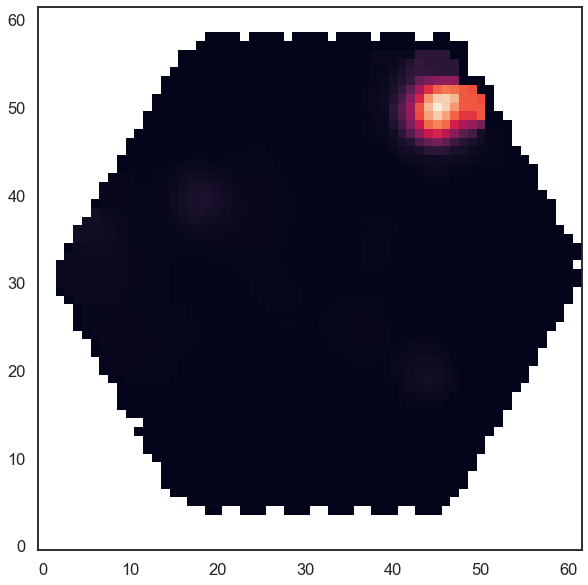

In [3]:
org_cube__wyx = fits.getdata(os.path.join(PRODUCTS_PATH, "obs", f"{POINTING}.cube.fits.gz"))
obs_lum_band = np.nanmedian(org_cube__wyx[mask_norm], axis=0)

plt.figure(figsize=(10,10))
plt.imshow(np.ma.masked_array(obs_lum_band, mask=seg_map__yx==0), origin="lower")

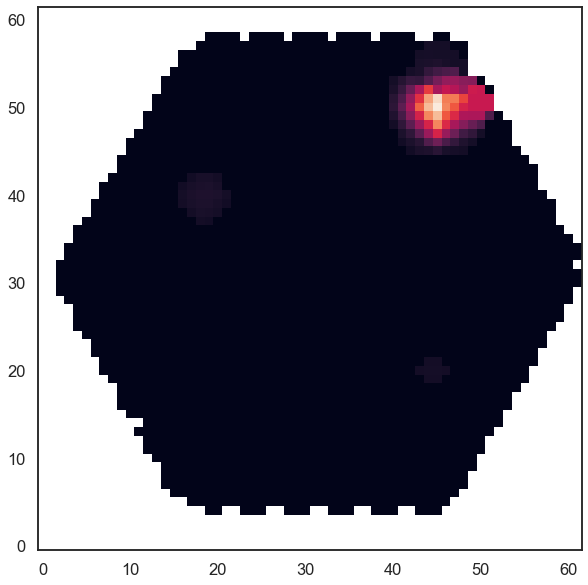

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(np.ma.masked_array(lum_band, mask=seg_map__yx==0), origin="lower")

In [13]:
# plt.figure(figsize=(10,10))
# plt.imshow(np.ma.masked_array(moments["LOGG"], mask=seg_map__yx==0), origin="lower", cmap="rainbow")
# plt.colorbar()

In [6]:
from astropy.wcs import WCS
from reproject.mosaicking import find_optimal_celestial_wcs


CUBE_PATTERN = ".cube.fits.gz"

G_WAVE = 4672-500, 4672+500
R_WAVE = 6141-500, 6141+500
I_WAVE = 7458-500, 7458+500

plates = [9673, 9674, 9675]+list(range(10141,10151))+list(range(10480,10492))+list(range(12027,12051))
ifus = [9101, 9102, 12701, 12702, 12703, 12704, 12705]

MANGA_NAME = "manga-{}-{}.cube.fits.gz"
names = []
for plate, ifu in it.product(plates, ifus):
    names.append(MANGA_NAME.format(plate,ifu))

org_cube_paths = sorted([os.path.join(root,file) for root, _, files in os.walk(os.path.join(PRODUCTS_PATH,"obs")) for file in files if file.endswith(CUBE_PATTERN) and file in names])
# ipointing = sorted([file for root, _, files in os.walk(os.path.join(PRODUCTS_PATH,"obs")) for file in files if file.endswith(CUBE_PATTERN) and file in names]).index(f"{POINTING}{CUBE_PATTERN}"

hdus = []
for icube, org_cube_path in tqdm(enumerate(org_cube_paths), total=len(org_cube_paths), desc="extracting gri-band image", unit="cube", ascii=True):

    label = os.path.basename(org_cube_path).replace(CUBE_PATTERN,"")

    if label == POINTING: ipointing = icube

    # read IC342 original cube
    org_cube = fits.open(org_cube_path, memmap=False)
    org_cube__wyx, org_header = org_cube[0].data, org_cube[0].header
    org_wave__w = get_wave_from_header(org_header, wave_axis=3)

    mask_img = (np.nan_to_num(org_cube__wyx)!=0).any(axis=0)

    # compute gri-band image of each cube
    g_image = np.nanmedian(org_cube__wyx[(G_WAVE[0]<=org_wave__w)&(org_wave__w<=G_WAVE[1])], axis=0)
    g_image[~mask_img] = np.nan
    r_image = np.nanmedian(org_cube__wyx[(R_WAVE[0]<=org_wave__w)&(org_wave__w<=R_WAVE[1])], axis=0)
    r_image[~mask_img] = np.nan
    i_image = np.nanmedian(org_cube__wyx[(I_WAVE[0]<=org_wave__w)&(org_wave__w<=I_WAVE[1])], axis=0)
    i_image[~mask_img] = np.nan

    new_header = copy(org_header)
    del new_header["*3"]
    del new_header["PLATEID"]
    del new_header["DATE-OBS"]
    hdu_g = fits.ImageHDU(data=g_image, header=new_header)
    hdu_r = fits.ImageHDU(data=r_image, header=new_header)
    hdu_i = fits.ImageHDU(data=i_image, header=new_header)
    hdus.append((hdu_g,hdu_r,hdu_i))

extracting gri-band image: 100%|##########| 342/342 [11:29<00:00,  2.02s/cube]


In [7]:
from astropy.coordinates import SkyCoord

from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd

from astropy.visualization import make_lupton_rgb


# build mosaic
reference_coord = SkyCoord.from_name("IC342")

g_hdus, r_hdus, i_hdus = list(zip(*hdus))
wcs_out, shape_out = find_optimal_celestial_wcs(g_hdus, reference=reference_coord)

g_pointing = copy(g_hdus[ipointing].data)
r_pointing = copy(r_hdus[ipointing].data)
i_pointing = copy(i_hdus[ipointing].data)

g_hdus[ipointing].data = np.ones_like(g_hdus[ipointing].data)*999
g_hdus[ipointing].data[~mask_img] = np.nan
r_hdus[ipointing].data = np.ones_like(r_hdus[ipointing].data)*999
r_hdus[ipointing].data[~mask_img] = np.nan
i_hdus[ipointing].data = np.ones_like(i_hdus[ipointing].data)*999
i_hdus[ipointing].data[~mask_img] = np.nan

g_mosaic, _ = reproject_and_coadd(g_hdus, wcs_out, shape_out=shape_out, reproject_function=reproject_interp)
r_mosaic, _ = reproject_and_coadd(r_hdus, wcs_out, shape_out=shape_out, reproject_function=reproject_interp)
i_mosaic, _ = reproject_and_coadd(i_hdus, wcs_out, shape_out=shape_out, reproject_function=reproject_interp)

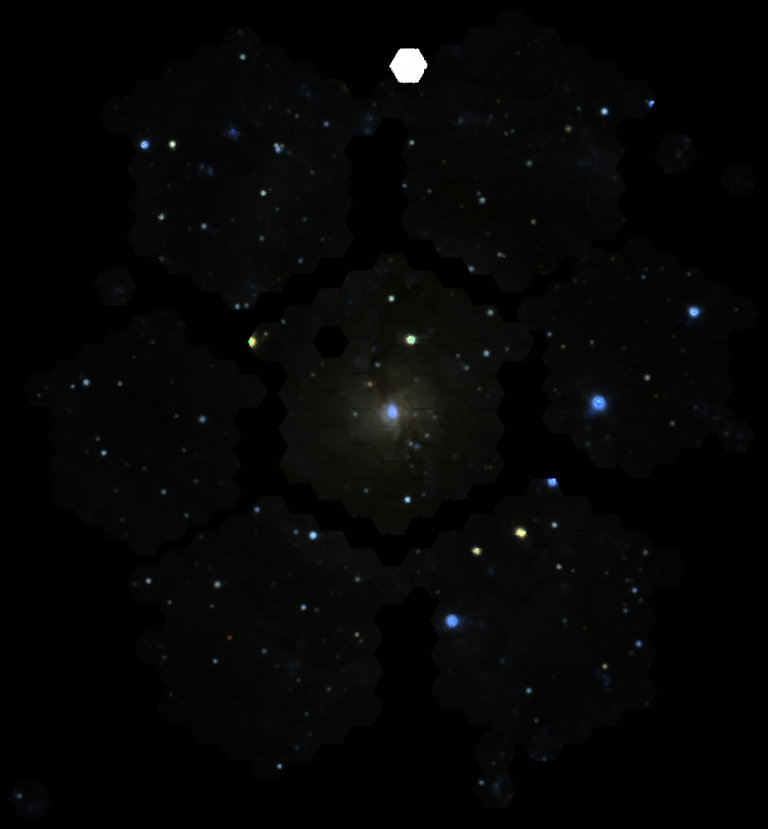

In [8]:

rgb_mosaic = make_lupton_rgb(i_mosaic, r_mosaic, g_mosaic, stretch=1, Q=5)

fig, ax = plt.subplots(figsize=(15,15), subplot_kw={'projection': wcs_out})
ax.set_aspect("equal")
ax.imshow(rgb_mosaic, origin="lower")
ax.tick_params("x", bottom=False, top=False)
ax.tick_params("y", left=False, right=False)
ax.axis("off")
fig.set_facecolor("#000")

# compute Halpha image of each cube
# overlay contours of Halpha on mosaic

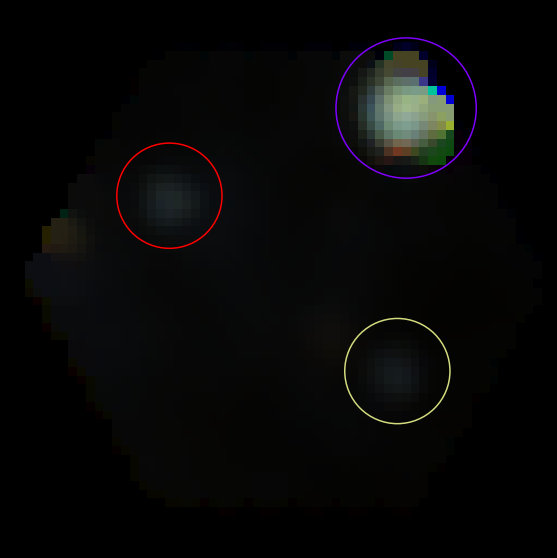

In [64]:
from matplotlib.patches import Circle


rgb_pointing = make_lupton_rgb(i_pointing, r_pointing, g_pointing, stretch=1, Q=5)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect("equal")
ax.imshow(rgb_pointing, origin="lower")

spaxels = np.column_stack(np.where(seg_map__yx!=0))

region_a = Circle((45,50), 8, fc="none", ec="#7F00FF")
region_b = Circle((18,40), 6, fc="none", ec="#FF0000")
region_c = Circle((44,20), 6, fc="none", ec="#D4DC7F")
mask_a = region_a.contains_points(spaxels)
mask_b = region_b.contains_points(spaxels)
mask_c = region_c.contains_points(spaxels)

masks = [mask_a,mask_b,mask_c]
regions = [region_a,region_b,region_c]
[ax.add_patch(region) for region in regions]

ax.axis("off")
fig.set_facecolor("#000")

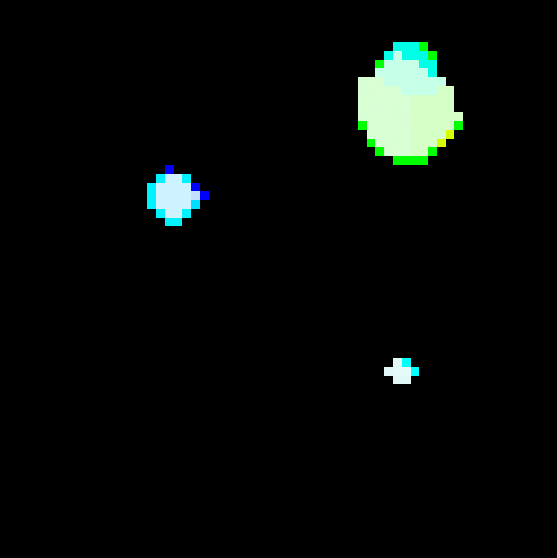

In [45]:
g_image_rsp = np.nanmedian(rsp_mod_cube__wyx[(G_WAVE[0]<=rsp_wave__w)&(rsp_wave__w<=G_WAVE[1])], axis=0)
g_image_rsp[~mask_img] = np.nan
r_image_rsp = np.nanmedian(rsp_mod_cube__wyx[(R_WAVE[0]<=rsp_wave__w)&(rsp_wave__w<=R_WAVE[1])], axis=0)
r_image_rsp[~mask_img] = np.nan
i_image_rsp = np.nanmedian(rsp_mod_cube__wyx[(I_WAVE[0]<=rsp_wave__w)&(rsp_wave__w<=I_WAVE[1])], axis=0)
i_image_rsp[~mask_img] = np.nan

rgb_pointing = make_lupton_rgb(i_image_rsp, r_image_rsp, g_image_rsp, stretch=1, Q=5)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect("equal")
ax.imshow(rgb_pointing, origin="lower")

# [ax.add_patch(region) for region in regions]

ax.axis("off")
fig.set_facecolor("#000")

# fig, ax = plt.subplots(figsize=(20,5))

# for i in range(len(regions)):
#     star_ix, star_iy = spaxels[masks[i]].T
#     # ax.step(org_wave__w, org_cube__wyx[:, star_iy, star_ix].sum(axis=-1), color="k", lw=1)
#     wl, fl = rsp_wave__w, np.nansum(rsp_mod_cube__wyx[:, star_iy, star_ix], axis=-1)
#     mask_norm = (WAVE_NORM[0]<=wl)&(wl<=WAVE_NORM[1])
#     fl /= fl[mask_norm].mean()
#     ax.step(wl, fl, color=regions[i].get_edgecolor(), lw=1)
# ax.set_xlim(3800,9500)

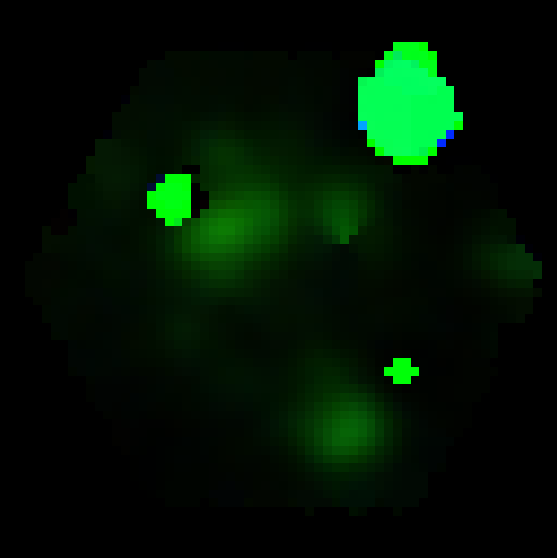

In [63]:
gas_mod = fits.open(os.path.join(OUTPUT_PATH,f"{POINTING}-gas.cube.fits.gz"), memmap=False)
gas_mod_cube__wyx = gas_mod[0].data
gas_wave__w = get_wave_from_header(gas_mod[0].header, wave_axis=3)

O_WAVE = 5006.84-5, 5006.84+5
H_WAVE = 6562.85-5, 6562.85+5
S_WAVE = 6716.44-5, 6730.82+5

o_image_gas = np.nanmedian(gas_mod_cube__wyx[(O_WAVE[0]<=gas_wave__w)&(gas_wave__w<=O_WAVE[1])], axis=0)
o_image_gas[~mask_img] = np.nan
h_image_gas = np.nanmedian(gas_mod_cube__wyx[(H_WAVE[0]<=gas_wave__w)&(gas_wave__w<=H_WAVE[1])], axis=0)
h_image_gas[~mask_img] = np.nan
s_image_gas = np.nanmedian(gas_mod_cube__wyx[(S_WAVE[0]<=gas_wave__w)&(gas_wave__w<=S_WAVE[1])], axis=0)
s_image_gas[~mask_img] = np.nan

rgb_pointing = make_lupton_rgb(s_image_gas, h_image_gas, o_image_gas, stretch=1, Q=5)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect("equal")
ax.imshow(rgb_pointing, origin="lower")

# [ax.add_patch(region) for region in regions]

ax.axis("off")
fig.set_facecolor("#000")

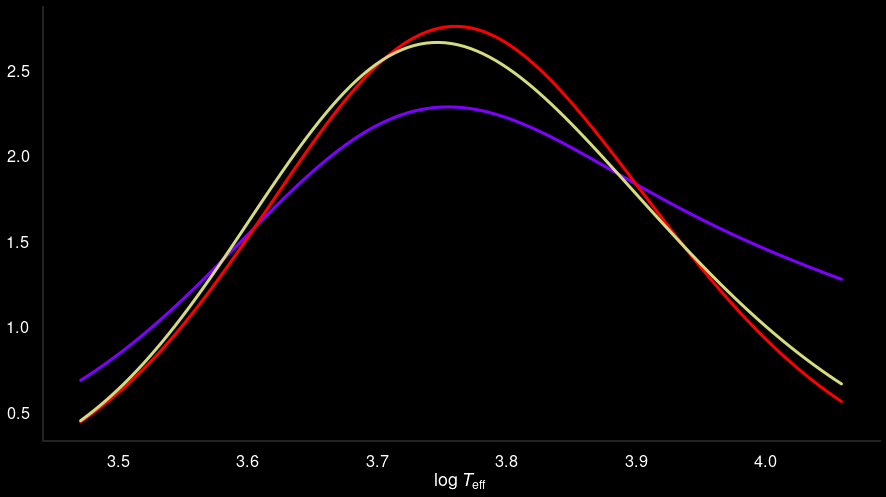

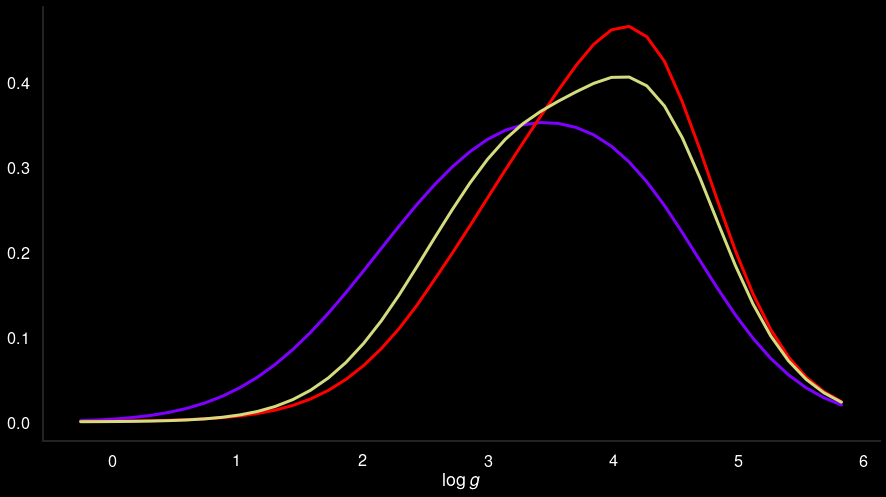

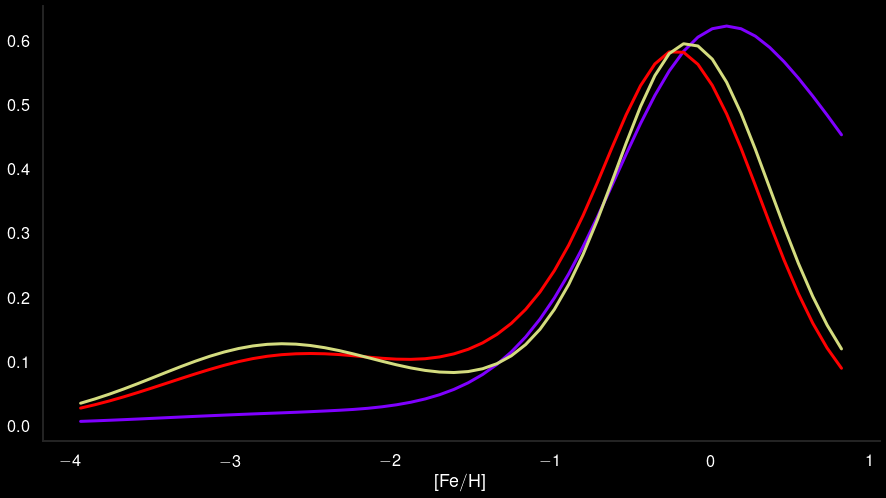

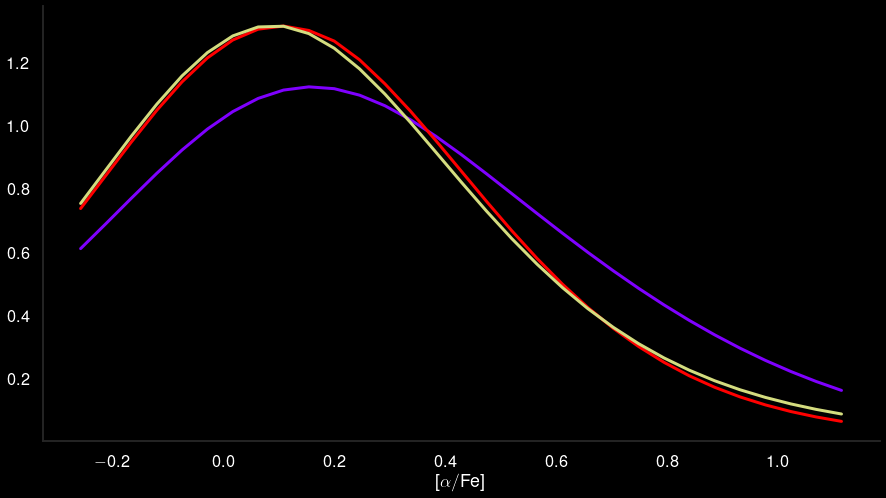

In [12]:
from matplotlib import rc


latex_preamble = "\n".join([
    r"\usepackage{helvet}",
    r"\usepackage{amsmath}",
    r"\usepackage[helvet]{sfmath}",
    r"\renewcommand{\familydefault}{\sfdefault}"
])

text = {"usetex":True, "latex.preamble":latex_preamble, "hinting":"native"}
rc("text", **text)

labels = {"TEFF":r"$\log{T_\text{eff}}$", "LOGG":r"$\log{g}$", "MET":r"$[\text{Fe}/\text{H}]$", "ALPHAM":r"$[\alpha/\text{Fe}]$"}

for j, name in enumerate(PARAM_NAMES):
    fig, ax = plt.subplots(figsize=(15,8))
    fig.set_facecolor("#000")
    ax.set_facecolor("#000")
    ax.tick_params(colors="w")
    for i in range(len(regions)):
        star_ix, star_iy = spaxels[masks[i]].T
        x, pdf = voxel_supp[name], cube_pdfs[name][:, star_iy, star_ix].sum(axis=-1)
        pdf = normalize_to_pdf(pdf, x)
        ax.plot(x, pdf, lw=3, color=regions[i].get_edgecolor())
        ax.set_xlabel(labels[name])
        # ax.tick_params("y", labelleft=False)
        ax.xaxis.label.set_color("w")
        sns.despine(ax=ax)